In [149]:
%matplotlib inline
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.dummy import DummyRegressor
from sklearn.gaussian_process import GaussianProcess
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.grid_search import RandomizedSearchCV
from pyearth import Earth
from copy import deepcopy
from sklearn.ensemble import partial_dependence as pd
from xgboost import XGBRegressor


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [10]:
data = np.load('resultats_A.dat.npy')
data = data.T
X_full = data[:, 0:6]
y = data[:, 6]
print(data.shape, X_full.shape, y.shape)

((10000, 7), (10000, 6), (10000,))


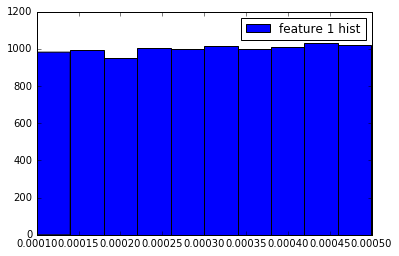

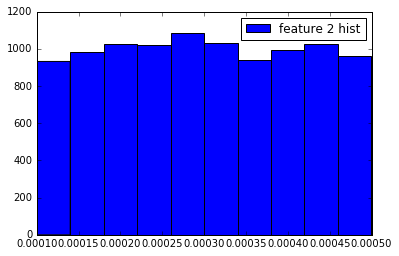

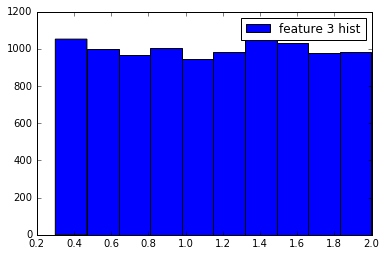

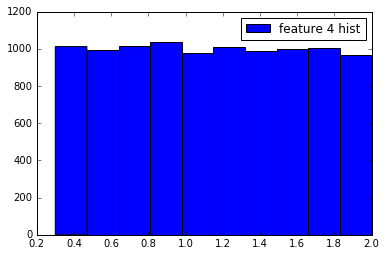

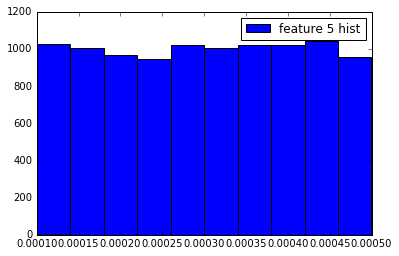

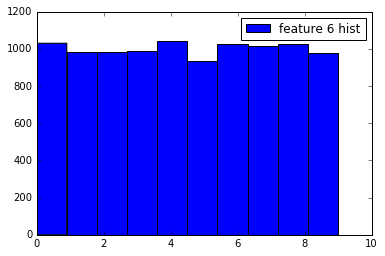

In [11]:
for i in range(X_full.shape[1]):
    plt.hist(X_full[:, i], label='feature {} hist'.format(i + 1))
    plt.legend()
    plt.show()

In [234]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

imp = []

def train_and_get_results(reg, X_full, y, score_fn=r2_score, n_folds=5):
    X = X_full    
    folds = KFold(X.shape[0], n_folds=n_folds)
    scores_train = []
    scores_test = []
    models = []
    for train, test in folds:
        reg_ = clone(reg)

        m = y[train].mean()
        s = y[train].std()

        # useful if neural nets are used because the output is very small
        def rescale(y):
            return (y - m)  / s
        
        def inv_rescale(y):
            return y * s + m
        
        reg_.fit(X[train], rescale(y[train]))

        score = score_fn(y[train], inv_rescale(reg_.predict(X[train])))
        scores_train.append(score)

        score = score_fn(y[test] , inv_rescale(reg_.predict(X[test])))
        scores_test.append(score)
        models.append(reg_)
        if hasattr(reg_, 'feature_importances_'):
            imp.append(reg_.feature_importances_)
    return scores_train, scores_test, models

rf_param_dist = {"max_depth": sp_randint(1, 100),
              "n_estimators": sp_randint(1, 100),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False]}
gb_params_dist= {
    "learning_rate": sp_uniform(0, 1), 
    "n_estimators": sp_randint(1, 200), 
    "max_depth": sp_randint(1, 100)
}
regs = [
    DummyRegressor(strategy='mean'),
    LinearRegression(),
    RandomForestRegressor(max_depth=30, n_estimators=50),
    #AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear',),
    Earth(max_degree=5, max_terms=20),
    #XGBRegressor(n_estimators=100, max_depth=50, learning_rate=0.01)
    GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=5),
    #RandomizedSearchCV(RandomForestRegressor(), param_distributions=rf_param_dist, n_iter=100)
    #RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=gb_params_dist, n_iter=100)
]

In [235]:
score_fn = root_mean_squared_error
results = map(lambda reg:train_and_get_results(reg, X_full, y, score_fn=score_fn, n_folds=5), regs)

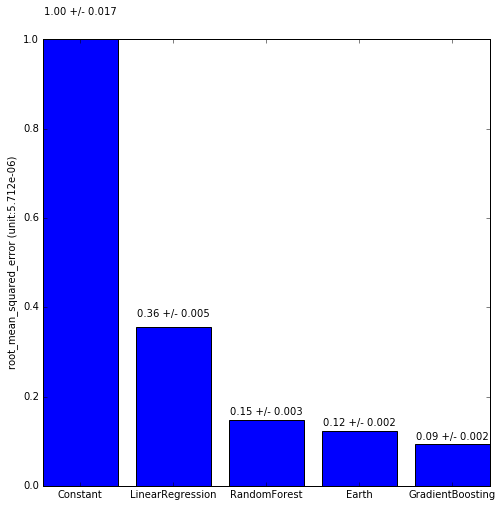

In [236]:
test_mean = np.array([np.mean(scores_test) for scores_train, scores_test, models in results])
test_std = np.array([np.std(scores_test) for scores_train, scores_test, models in results])

train_mean = [np.mean(scores_train) for scores_train, scores_test, models in results]
train_std = [np.std(scores_train) for scores_train, scores_test, models in results]

names = [reg.__class__.__name__.replace('Regressor', '').replace('Dummy', 'Constant') for reg in regs]
ind = np.arange(len(regs))

fig, ax = plt.subplots(figsize=(8, 8))

width = 0.8
plt.xticks(ind + width/2., names)

rects = plt.bar(ind, test_mean / test_mean.max(), width=width, color='blue')
#rect2 = plt.bar(ind, train_mean, width=width, color='red')
for i, rect in enumerate(rects):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05 * height,
            '%.2f +/- %.3f' % (test_mean[i] / test_mean.max(), test_std[i] / test_mean.max()),
             ha='center', va='bottom')
plt.ylabel('{} (unit:{:03.03e})'.format(score_fn.__name__, test_mean.max()))

[ 0.16300837  0.08367697  0.18975605  0.18476559  0.18267121  0.1961218 ]


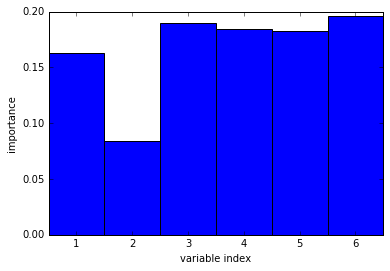

In [240]:
k=5
ind = (np.arange(len(imp[k])))
print(imp[k])
plt.xticks(ind + 0.5, np.arange(1, len(imp[k]) + 1))
plt.bar(ind, imp[k], width=1)
plt.xlabel('variable index')
plt.ylabel('importance')

In [242]:
print(sum(imp[k]))

1.0


(<matplotlib.figure.Figure at 0x7fe8696de750>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fe869015750>])

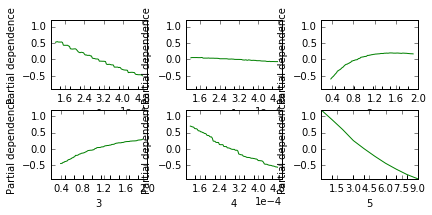

In [169]:
all_models = [models[0] for scores_train, scores_test, models in results]

pd.plot_partial_dependence(all_models[4], X_full,
                           [0, 1, 2, 3, 4, 5])